# Forest Cover Problem

## Objective
The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1 - Spruce/Fir
2 - Lodgepole Pine
3 - Ponderosa Pine
4 - Cottonwood/Willow
5 - Aspen
6 - Douglas-fir
7 - Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

## Steps to complete the project
The following steps must be completed to successfully complete this project
1. Read in data and clean
2. Data visualization to uncover trends
3. Feature engineering
4. Training algorithm
5. Testing algorithm
6. Optional - Ensembling

## Reading data and cleaning

Let us start off by importing important data science libraries and reading in the training and testing data. The training and testing data should be combined and shuffled to do some exploratory analysis

In [1]:
# Importing data handling libraries numpy and pandas
import numpy as np
import pandas as pd

#Importing visualization libraries matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [9]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
combined = train.append(test, ignore_index = True) # Does not keep index

Before we go into the data visualization, we need to check if there are any missing values in the training or testing datasets. 

In [3]:
# Checking NaN in training dataset
train.isnull().values.any()

False

In [4]:
# Checking NaN in testing dataset
test.isnull().values.any()

False

An initial check reveals that there is no missing values in the form of NaN, but sometimes, the database creators may have inputted the missing value as a '0' or another value that does not make sense in context. This will be covered in the data visualization part of the notebook. 

Checking the head of the dataset, specifically the target variable "Cover_Type"

In [12]:
combined.head()

,Aspect,Cover_Type,Elevation,Hillshade_3pm,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Id,...,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Vertical_Distance_To_Hydrology,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,51,5.0,2596,148,221,232,6279,258,510,1,...,0,0,0,0,0,0,1,0,0,0
1,56,5.0,2590,151,220,235,6225,212,390,2,...,0,0,0,0,0,-6,1,0,0,0
2,139,2.0,2804,135,234,238,6121,268,3180,3,...,0,0,0,0,0,65,1,0,0,0
3,155,2.0,2785,122,238,238,6211,242,3090,4,...,0,0,0,0,0,118,1,0,0,0
4,45,5.0,2595,150,220,234,6172,153,391,5,...,0,0,0,0,0,-1,1,0,0,0


Furthermore, one-hot encoding should be performed on categorical variables. However, looking at the metadata, it seems that any potential categorical variables has already been one-hot encoded. Let us check whether these encoded variables are categorical. If not, we will factorize them. (http://pbpython.com/categorical-encoding.html)

In [7]:
combined.dtypes # Categorical variables should be in "obj" form

Aspect                                  int64
Cover_Type                            float64
Elevation                               int64
Hillshade_3pm                           int64
Hillshade_9am                           int64
Hillshade_Noon                          int64
Horizontal_Distance_To_Fire_Points      int64
Horizontal_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways         int64
Id                                      int64
Slope                                   int64
Soil_Type1                              int64
Soil_Type10                             int64
Soil_Type11                             int64
Soil_Type12                             int64
Soil_Type13                             int64
Soil_Type14                             int64
Soil_Type15                             int64
Soil_Type16                             int64
Soil_Type17                             int64
Soil_Type18                             int64
Soil_Type19                       

It seems that these variables are not encoded categorically. The following variables must be encoded categorically
* Soil_TypeN
* Wilderness_AreaN 
* Cover_Type

In [3]:
soilTypesCols = [col for col in combined.columns if 'Soil_Type' in col] # List of all variables with Soil_Type
wildernessAreaCols = [col for col in combined.columns if 'Wilderness_Area' in col]

print(soilTypesCols)
print(wildernessAreaCols)

# Converting variables to category

for col in soilTypesCols:
    combined[col] = combined[col].astype('category')
    
for col in wildernessAreaCols:
    combined[col] = combined[col].astype('category')

combined["Cover_Type"] = combined["Cover_Type"].astype('category')

['Soil_Type1', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type2', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type3', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type4', 'Soil_Type40', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9']
['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']


With that, the variables that we need are all categorical. Any more data cleaning can only be done with a more indepth look into the data with visualizations.

## Exploratory Data Analysis

There are a couple of objectives I would like to meet in the EDA:
1. Check for the distribution of variables and normalize outliers
2. Standardize all variables
3. Check for covariation

I will start off by plotting the class balance for the variable Cover_Type

In [15]:
# Training set balance
train["Cover_Type"].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

It seems that the data distribution for the predicting variable is balanced! I will now check for outliers in the continuous variables via boxplot figures

Text(0.5,1,'Slope distribution')

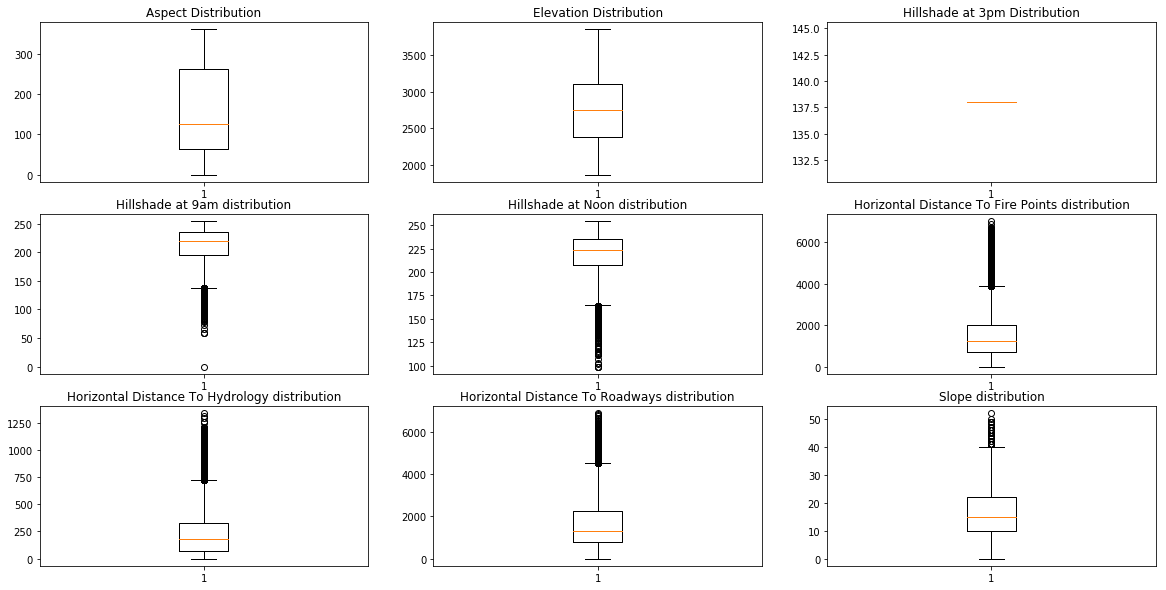

In [8]:
# Creating subplots for faster analysis
fig, axs = plt.subplots(3, 3)

#Aspect
axs[0,0].boxplot(train["Aspect"])
axs[0,0].set_title("Aspect Distribution")

#Elevation
axs[0, 1].boxplot(train["Elevation"])
axs[0, 1].set_title("Elevation Distribution")

#Hillshade_3pm
axs[0, 2].boxplot(train["Hillshade_3pm"])
axs[0, 2].set_title("Hillshade at 3pm Distribution")

#Hillshade_9am
axs[1, 0].boxplot(train["Hillshade_9am"])
axs[1, 0].set_title("Hillshade at 9am distribution")

#Hillshade_Noon
axs[1, 1].boxplot(train["Hillshade_Noon"])
axs[1, 1].set_title("Hillshade at Noon distribution")

#Horizontal_Distance_To_Fire_Points
axs[1, 2].boxplot(train["Horizontal_Distance_To_Fire_Points"])
axs[1, 2].set_title("Horizontal Distance To Fire Points distribution")

#Horizontal_Distance_To_Hydrology 
axs[2, 0].boxplot(train["Horizontal_Distance_To_Hydrology"])
axs[2, 0].set_title("Horizontal Distance To Hydrology distribution")

#Horizontal_Distance_To_Roadways 
axs[2, 1].boxplot(train["Horizontal_Distance_To_Roadways"])
axs[2, 1].set_title("Horizontal Distance To Roadways distribution")

#Slope 
axs[2, 2].boxplot(train["Slope"])
axs[2, 2].set_title("Slope distribution")

From the subplots, we can see that there are a lot of outliers for hillshade variables, horizontal distance variables and slope distribution variables (as symbolized by the dots outside the IQR. If we were to leave these outliers, it could create a lot of problems in training algorithms. What is interesting about these outliers is that they are all on one tail, which makes sense (you cannot have negative outliers for horizontal distance from hydrology). 

Although outliers may affect the performance of these algorithms, it is important to note that the outliers present here are not from a technical glitch or bad collection: it is simply the nature of the data. Removing outliers might be foolish in this situation as we would be removing valuable data.

We also notice in this dataset that there are plentiful variables. While that is great, the fact that they are not in the same scale is worrisome. To solve for this problem, we will be using standadization. Each variable will be converted to a normal distribution with mean 0 and unit variance. 

In [16]:
from sklearn import preprocessing

scaling_data = combined.drop()


['Soil_Type1', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type2', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type3', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type4', 'Soil_Type40', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9']
